# Sports

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from sports revisions and sports items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/sports_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/sports.csv')

In [3]:
print("Number of Revisions in Sports Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Sports Dataset")
print(items.shape)

Number of Revisions in Sports Dataset
(619242, 12)
Number of Wikidata Items in Sports Dataset
(154761, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(619242, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    154409.000000
mean          3.989107
std           6.828380
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         507.000000
Name: qid, dtype: float64

In [15]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [16]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
56098
Items with No of Edits = 2
44262
Items with No of Edits = 3
14784
Items with No of Edits = 4
7920
Items with No of Edits = 5
4007
Items with No of Edits <= 5
127071


In [17]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [18]:
df_editscount.shape

(27338, 2)

In [19]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [20]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [21]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [22]:
print(df_editscount.head())
print(df_editscount[df_editscount['qid'] == 'Q4115189'])
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])

        qid  editscount
0   Q155965         507
1   Q245970         388
2   Q381121         320
3  Q2186582         319
4  Q1395335         315
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []


In [23]:
print("Number of Revisions in Sports Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Sports Dataset after Data Cleaning")
sports_items = rev['qid'].value_counts()
print(sports_items.shape)

Number of Revisions in Sports Dataset after Data Cleaning
(375265, 10)
Number of Wikidata Items in Sports Dataset after Data Cleaning
(27338,)


# Descriptive Statistics

In [24]:
print(sports_items.describe().astype(int))

count    27338
mean        13
std         11
min          6
25%          8
50%         11
75%         16
max        507
Name: qid, dtype: int32


In [25]:
# converting a series to a dataframe
s_items = pd.DataFrame({'type':sports_items.index, 'count':sports_items.values})

In [26]:
# Items between the median and 75th percentile
print(s_items[(s_items['count'] >= 11) & (s_items['count'] < 16)])
# Items in the top 25% of the dataset
print(s_items[s_items['count'] >= 16])
# Items below median that is items that fall in the fist 50%
print(s_items[s_items['count'] < 11])
# Items that form the low 25% of the dataset
print(s_items[s_items['count'] < 8])
# Items that are part of 75% of the dataset
print(s_items[s_items['count'] < 16])

            type  count
7018   Q27570094     15
7019   Q27340429     15
7020   Q27880152     15
7021   Q27669695     15
7022   Q27522162     15
...          ...    ...
14267  Q27532175     11
14268  Q27867089     11
14269  Q27867490     11
14270  Q27349663     11
14271   Q3759566     11

[7254 rows x 2 columns]
           type  count
0       Q155965    507
1       Q245970    388
2       Q381121    320
3      Q2186582    319
4      Q1395335    315
...         ...    ...
7013  Q27878546     16
7014  Q27607369     16
7015  Q27606940     16
7016  Q27878971     16
7017  Q23893158     16

[7018 rows x 2 columns]
            type  count
14272    Q799328     10
14273  Q27878552     10
14274    Q929495     10
14275  Q27878514     10
14276  Q27878310     10
...          ...    ...
27333    Q590513      6
27334  Q27628566      6
27335  Q23304376      6
27336   Q2201832      6
27337  Q27903286      6

[13066 rows x 2 columns]
            type  count
20908  Q27867273      7
20909  Q27867562      7


# Statistics for Proxies

In [27]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [28]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

          count
type           
create   222149
add      127636
update    16797
remove     4444
set        3433
revert      321
merge       186
undo        181
restore     112
protect       6


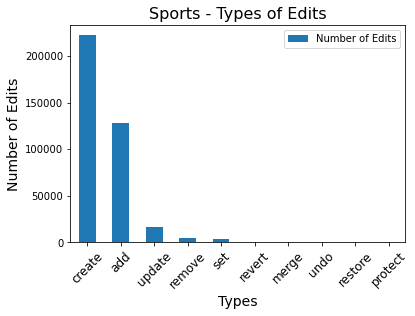

In [29]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Sports - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [30]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

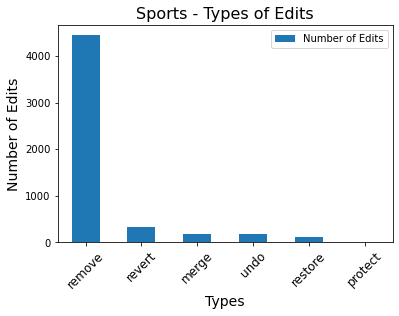

In [32]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Sports - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [33]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
revert     321
merge      186
undo       181
restore    112
protect      6


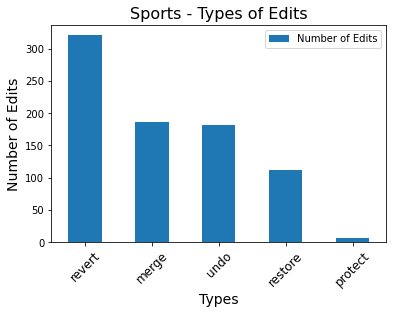

In [34]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Sports - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [36]:
no_of_edits = sports_items.to_numpy()

(array([1.4149e+04, 7.3610e+03, 2.6160e+03, 1.2200e+03, 1.1200e+03,
        9.6000e+01, 3.9600e+02, 9.3000e+01, 3.7000e+01, 3.9000e+01,
        1.7000e+01, 1.7000e+01, 1.9000e+01, 1.5000e+01, 1.7000e+01,
        1.7000e+01, 7.0000e+00, 1.5000e+01, 1.5000e+01, 1.1000e+01,
        9.0000e+00, 4.0000e+00, 8.0000e+00, 2.0000e+00, 6.0000e+00,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

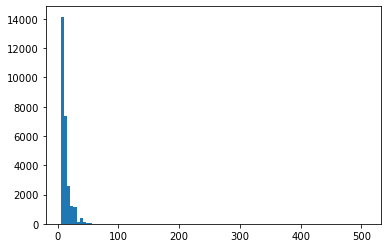

In [37]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

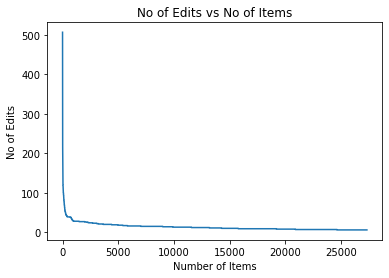

In [38]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [39]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [40]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [41]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [42]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [43]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [44]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [45]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [46]:
proxies = proxies.reset_index()

In [47]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [48]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [49]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [50]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [51]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [52]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,27338.000000,27338.000000,27338.000000,27338.000000,27338.000000,27338.000000,27338.000000,27338.000000
mean,0.011742,0.006804,0.006621,0.004097,0.000219,0.162558,13.726864,2.004536
std,0.190035,0.083966,0.121236,0.077818,0.014813,0.887076,11.963085,1.778117
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,3.000000
max,14.000000,2.000000,10.000000,5.000000,1.000000,74.000000,507.000000,42.000000


Text(0, 0.5, 'No of Edits')

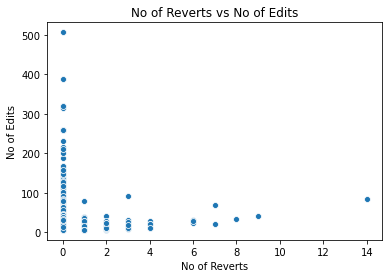

In [53]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

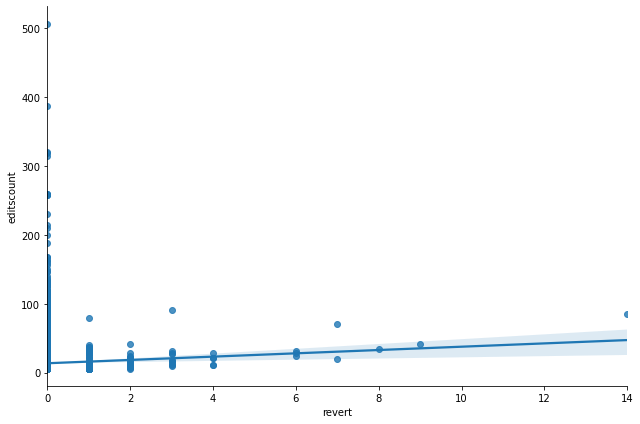

In [54]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [55]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.056891,0.236377,0.271322,0.194003,0.058116,0.038194,0.200767
merge,0.056891,1.000000,0.045883,0.118900,-0.001201,0.063238,-0.004523,0.144594
undo,0.236377,0.045883,1.000000,0.190995,0.039929,0.117885,0.065033,0.142231
restore,0.271322,0.118900,0.190995,1.000000,0.157888,0.169995,0.153899,0.117510
protect,0.194003,-0.001201,0.039929,0.157888,1.000000,0.011204,0.004880,0.031904
remove,0.058116,0.063238,0.117885,0.169995,0.011204,1.000000,0.260574,0.081120
editscount,0.038194,-0.004523,0.065033,0.153899,0.004880,0.260574,1.000000,-0.089200
userscount,0.200767,0.144594,0.142231,0.117510,0.031904,0.081120,-0.089200,1.000000


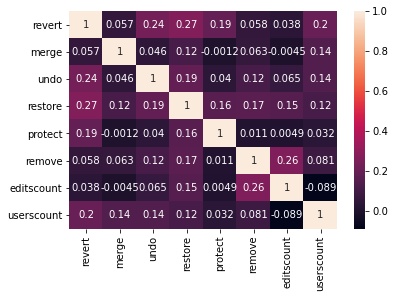

In [56]:
sns.heatmap(corr_matrix, annot=True)

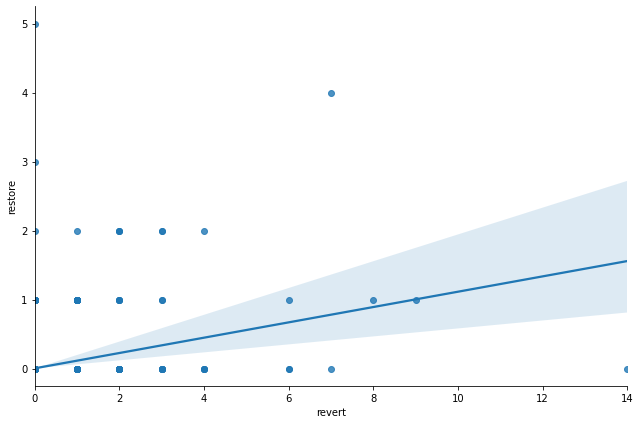

In [57]:
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

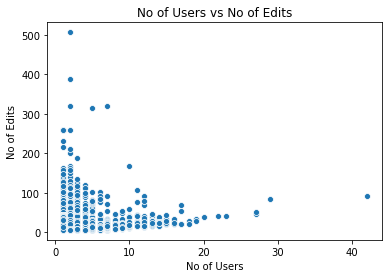

In [58]:
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

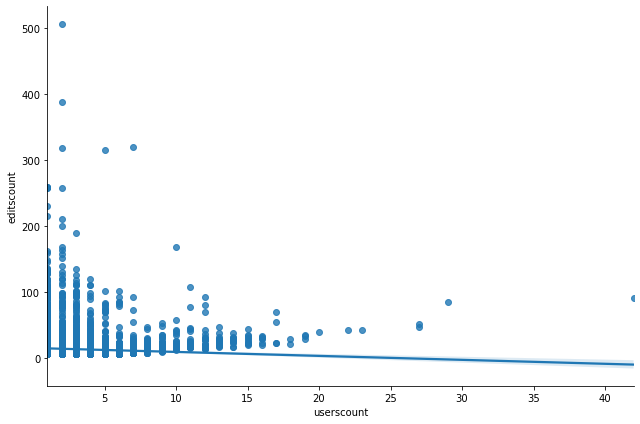

In [60]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [61]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [62]:
proxies.shape

(2696, 9)

In [63]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
0,Q2124328,0,0,0,0,0,1,6,2
4,Q2132419,0,0,0,0,0,2,6,1
7,Q2143177,0,0,0,0,0,2,7,4
11,Q2164976,0,0,0,0,0,5,11,1
29,Q2244311,0,0,0,0,0,2,7,1
...,...,...,...,...,...,...,...,...,...
27166,Q28061478,0,0,0,0,0,2,18,1
27221,Q28063912,0,0,0,0,1,0,8,3
27272,Q28065505,0,0,0,0,0,1,6,3
27276,Q28070854,0,0,0,0,0,2,27,2


In [64]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [65]:
proxies_without_remove.shape

(514, 9)

In [66]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.281730,0.073305,0.122709,0.223195,-0.016511,0.051193,0.312178
merge,-0.281730,1.000000,-0.248397,-0.138343,-0.064551,-0.051333,-0.097787,-0.029792
undo,0.073305,-0.248397,1.000000,0.048182,0.016118,0.109882,0.130918,0.142612
restore,0.122709,-0.138343,0.048182,1.000000,0.174150,0.209692,0.377049,0.066852
protect,0.223195,-0.064551,0.016118,0.174150,1.000000,-0.002831,0.013869,0.037332
remove,-0.016511,-0.051333,0.109882,0.209692,-0.002831,1.000000,0.582898,-0.027465
editscount,0.051193,-0.097787,0.130918,0.377049,0.013869,0.582898,1.000000,0.109691
userscount,0.312178,-0.029792,0.142612,0.066852,0.037332,-0.027465,0.109691,1.000000


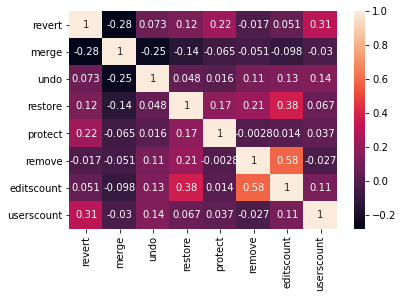

In [67]:
sns.heatmap(corr, annot=True)

# Top 20 

## Top 20 Reverts

In [68]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [69]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
331,Q2736,14,1,2,0,0,6,85,29
708,Q142794,9,0,2,1,0,0,41,11
549,Q46896,8,0,2,1,1,0,34,7
344,Q7156,7,1,2,4,0,4,70,17
12139,Q455462,7,0,0,0,0,1,20,6
345,Q8418,6,0,0,0,0,0,24,6
527,Q39444,6,0,1,1,0,0,31,9
12027,Q352159,6,0,0,0,0,2,28,7
301,Q615,4,0,0,2,1,2,28,12
505,Q29545,4,0,0,0,0,0,11,2


In [70]:
revert_item_labels = ['association football', 'Neymar', 'Zlatan Ibrahimović', 'FC Barcelona', 'Antoine Griezmann',
                     'handball', 'Ronaldinho', 'Stephen Curry', 'Lionel Messi', 'Kevin Durant', 
                     'Carlos Tevez', 'Mesut Özil', 'Sergi Enrich', 'Associação Chapecoense de Futebol', 'basketball', 
                     'Pelé', 'Kobe Bryant', 'José Mourinho', 'Radamel Falcao', 'Sergio Ramos']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [71]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
331,Q2736,association football,14,1,2,0,0,6,85,29
708,Q142794,Neymar,9,0,2,1,0,0,41,11
549,Q46896,Zlatan Ibrahimović,8,0,2,1,1,0,34,7
344,Q7156,FC Barcelona,7,1,2,4,0,4,70,17
12139,Q455462,Antoine Griezmann,7,0,0,0,0,1,20,6
345,Q8418,handball,6,0,0,0,0,0,24,6
527,Q39444,Ronaldinho,6,0,1,1,0,0,31,9
12027,Q352159,Stephen Curry,6,0,0,0,0,2,28,7
301,Q615,Lionel Messi,4,0,0,2,1,2,28,12
505,Q29545,Kevin Durant,4,0,0,0,0,0,11,2


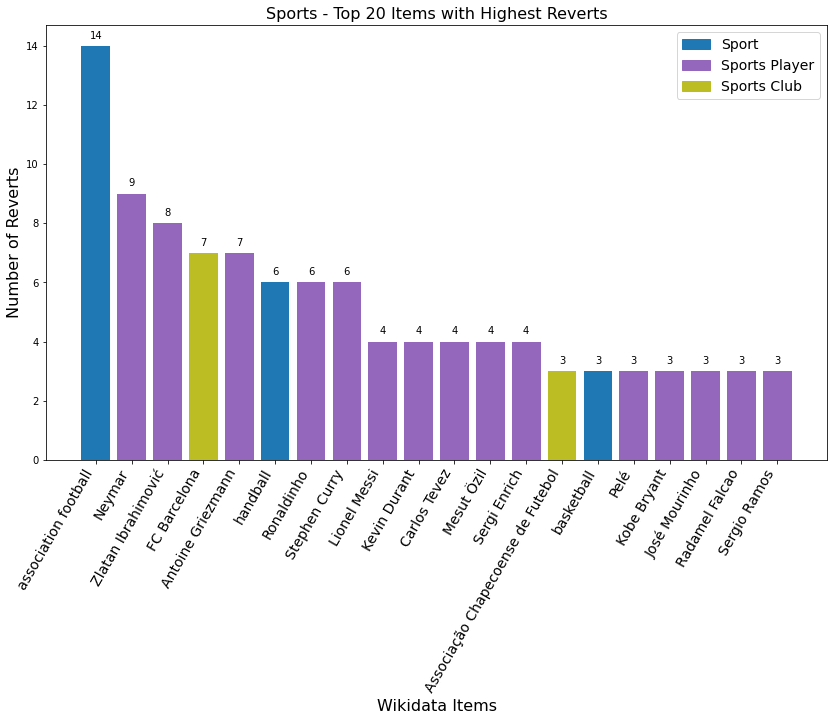

In [73]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.25, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:purple', 'tab:purple', 'tab:olive', 'tab:purple',
           'tab:blue', 'tab:purple', 'tab:purple', 'tab:purple', 'tab:purple',
           'tab:purple', 'tab:purple', 'tab:purple', 'tab:olive', 'tab:blue',
           'tab:purple', 'tab:purple', 'tab:purple', 'tab:purple', 'tab:purple']

sport = mpatches.Patch(color='tab:blue', label='Sport')
sports_player = mpatches.Patch(color='tab:purple', label='Sports Player')
sports_club = mpatches.Patch(color='tab:olive', label='Sports Club')

plt.legend(handles=[sport, sports_player, sports_club], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Sports - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [74]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [75]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
131,Q2436953,0,2,0,0,0,4,9,1
3138,Q23045163,0,2,0,0,0,0,21,18
3370,Q26250783,0,2,0,0,0,0,10,5
13672,Q22918509,0,2,0,0,0,0,7,5
202,Q2557477,0,1,0,0,0,0,11,6
276,Q2756090,0,1,0,0,0,0,7,2
318,Q1912,0,1,0,0,0,0,6,5
331,Q2736,14,1,2,0,0,6,85,29
344,Q7156,7,1,2,4,0,4,70,17
350,Q8682,0,1,0,0,0,2,29,11


In [76]:
merge_item_labels = ['Juan Rodríguez', '2016 Japanese Grand Prix', 'Linus Obexer', 'Marina Bourakova', 'UCI Road World Championship',
                     'BK Nový Jičín', 'Karim Benzema', 'association football', 'FC Barcelona', 'Real Madrid CF', 
                     'Diego Maradona', 'Birmingham City F.C.', 'S.C. Corinthians Paulista', 'Mesut Özil ', 'Claude Puel', 
                     'Swiss national football team', 'Poland national association football team', '1970 French Grand Prix', '1972 French Grand Prix', '1969 French Grand Prix']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [77]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
131,Q2436953,Juan Rodríguez,0,2,0,0,0,4,9,1
3138,Q23045163,2016 Japanese Grand Prix,0,2,0,0,0,0,21,18
3370,Q26250783,Linus Obexer,0,2,0,0,0,0,10,5
13672,Q22918509,Marina Bourakova,0,2,0,0,0,0,7,5
202,Q2557477,UCI Road World Championship,0,1,0,0,0,0,11,6
276,Q2756090,BK Nový Jičín,0,1,0,0,0,0,7,2
318,Q1912,Karim Benzema,0,1,0,0,0,0,6,5
331,Q2736,association football,14,1,2,0,0,6,85,29
344,Q7156,FC Barcelona,7,1,2,4,0,4,70,17
350,Q8682,Real Madrid CF,0,1,0,0,0,2,29,11


Text(0.5, 1.0, 'Sports - Top 20 Items with Highest Merges')

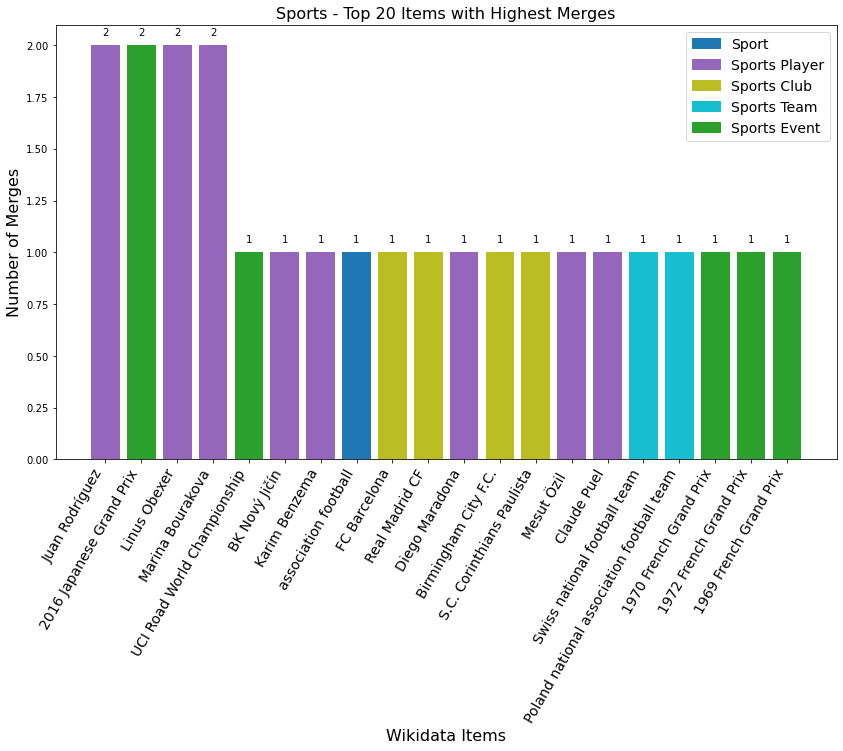

In [79]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:purple', 'tab:green', 'tab:purple', 'tab:purple', 'tab:green',
           'tab:purple', 'tab:purple', 'tab:blue', 'tab:olive', 'tab:olive',
           'tab:purple', 'tab:olive', 'tab:olive', 'tab:purple', 'tab:purple',
           'tab:cyan', 'tab:cyan', 'tab:green', 'tab:green', 'tab:green']

sport = mpatches.Patch(color='tab:blue', label='Sport')
sports_player = mpatches.Patch(color='tab:purple', label='Sports Player')
sports_club = mpatches.Patch(color='tab:olive', label='Sports Club')
sports_team = mpatches.Patch(color='tab:cyan', label='Sports Team')
sports_event = mpatches.Patch(color='tab:green', label='Sports Event')

plt.legend(handles=[sport, sports_player, sports_club, sports_team, sports_event], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Sports - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [80]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [81]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
3161,Q25239572,0,0,10,0,0,11,38,14
2969,Q20983771,0,0,7,0,0,1,9,3
336,Q5372,3,0,5,2,0,0,28,12
361,Q9616,1,0,5,0,0,3,38,13
1629,Q4760757,0,0,4,0,0,0,13,4
11585,Q3179425,0,1,3,0,0,2,10,3
195,Q2536715,3,0,2,1,0,2,91,42
203,Q2559284,0,0,2,0,0,0,6,6
223,Q2599716,2,0,2,2,0,0,10,4
331,Q2736,14,1,2,0,0,6,85,29


In [82]:
undo_item_labels = ['2016–17 UEFA Europa League knockout phase', 'Yuriy Kolomoyets', 'basketball', 'Chelsea F.C.', 'Andy Halliday',
                     'Jo Yun-mi', 'Associação Chapecoense de Futebol', 'Fuad Anwar', 'Alberto Martínez Díaz', 'association football', 
                     'FC Barcelona', 'RCD Espanyol de Barcelona', 'Hull City A.F.C.', 'Zlatan Ibrahimović', 'Neymar', 
                     'FC Okean Nakhodka', '2005 Sunfeast Open–singles', 'Farid El Alagui', 'Rosario Central', 'La Liga']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [83]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
3161,Q25239572,2016–17 UEFA Europa League knockout phase,0,0,10,0,0,11,38,14
2969,Q20983771,Yuriy Kolomoyets,0,0,7,0,0,1,9,3
336,Q5372,basketball,3,0,5,2,0,0,28,12
361,Q9616,Chelsea F.C.,1,0,5,0,0,3,38,13
1629,Q4760757,Andy Halliday,0,0,4,0,0,0,13,4
11585,Q3179425,Jo Yun-mi,0,1,3,0,0,2,10,3
195,Q2536715,Associação Chapecoense de Futebol,3,0,2,1,0,2,91,42
203,Q2559284,Fuad Anwar,0,0,2,0,0,0,6,6
223,Q2599716,Alberto Martínez Díaz,2,0,2,2,0,0,10,4
331,Q2736,association football,14,1,2,0,0,6,85,29


Text(0.5, 1.0, 'Sports - Top 20 Items with Highest Undos')

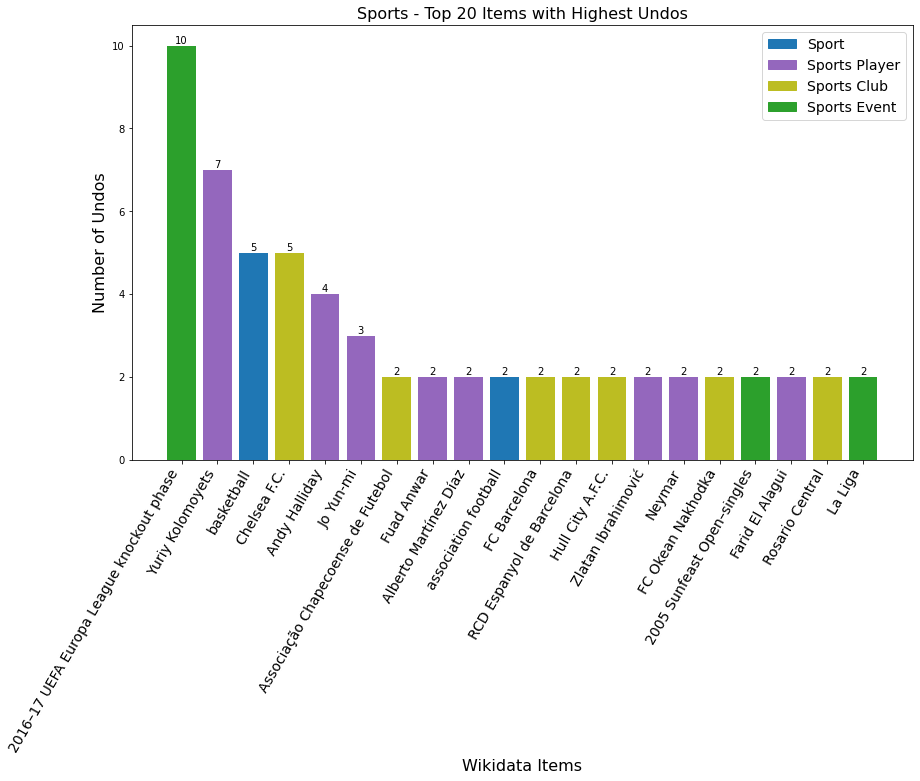

In [84]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:green', 'tab:purple', 'tab:blue', 'tab:olive', 'tab:purple',
           'tab:purple', 'tab:olive', 'tab:purple', 'tab:purple', 'tab:blue',
           'tab:olive', 'tab:olive', 'tab:olive', 'tab:purple', 'tab:purple',
           'tab:olive', 'tab:green', 'tab:purple', 'tab:olive', 'tab:green']

sport = mpatches.Patch(color='tab:blue', label='Sport')
sports_player = mpatches.Patch(color='tab:purple', label='Sports Player')
sports_club = mpatches.Patch(color='tab:olive', label='Sports Club')
sports_event = mpatches.Patch(color='tab:green', label='Sports Event')

plt.legend(handles=[sport, sports_player, sports_club, sports_event], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Sports - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [85]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [86]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
724,Q155965,0,0,1,5,0,10,507,2
344,Q7156,7,1,2,4,0,4,70,17
12046,Q368441,0,0,0,3,0,1,18,4
223,Q2599716,2,0,2,2,0,0,10,4
301,Q615,4,0,0,2,1,2,28,12
336,Q5372,3,0,5,2,0,0,28,12
686,Q131728,2,0,0,2,1,1,21,5
805,Q180553,2,0,1,2,0,0,16,6
11789,Q245970,0,0,0,2,0,74,388,2
12569,Q924034,1,0,1,2,0,0,28,5


In [87]:
restore_item_labels = ['Cypriot First Division', 'FC Barcelona', 'James Rodríguez', 'Alberto Martínez Díaz', 'Lionel Messi',
                     'basketball', 'Impact Wrestling', 'Alexis Sánchez', 'Cypriot Cup', 'Edison Toloza', 
                     'Óscar Esteban Granados', 'Dayro Moreno', 'Associação Chapecoense de Futebol', 'A.C. Milan', 'Men\'s European Volleyball Championship', 
                     'Stephan El Shaarawy', 'Diego Maradona', 'Manchester United F.C.', 'Leicester City F.C.', 'Celtic F.C. ']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [88]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
724,Q155965,Cypriot First Division,0,0,1,5,0,10,507,2
344,Q7156,FC Barcelona,7,1,2,4,0,4,70,17
12046,Q368441,James Rodríguez,0,0,0,3,0,1,18,4
223,Q2599716,Alberto Martínez Díaz,2,0,2,2,0,0,10,4
301,Q615,Lionel Messi,4,0,0,2,1,2,28,12
336,Q5372,basketball,3,0,5,2,0,0,28,12
686,Q131728,Impact Wrestling,2,0,0,2,1,1,21,5
805,Q180553,Alexis Sánchez,2,0,1,2,0,0,16,6
11789,Q245970,Cypriot Cup,0,0,0,2,0,74,388,2
12569,Q924034,Edison Toloza,1,0,1,2,0,0,28,5


Text(0.5, 1.0, 'Sports - Top 20 Items with Highest Restores')

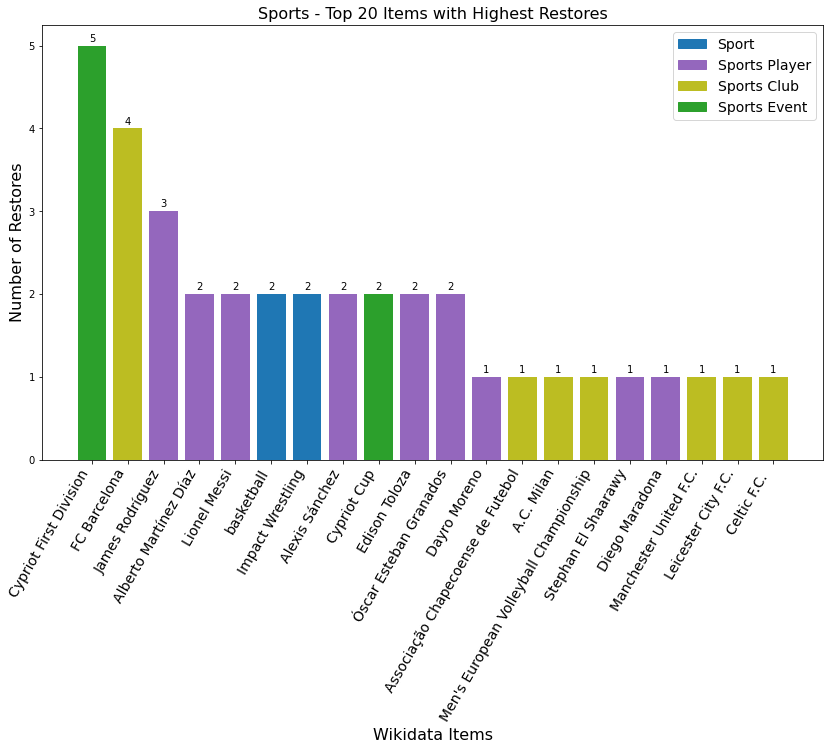

In [89]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:green', 'tab:olive', 'tab:purple', 'tab:purple', 'tab:purple',
           'tab:blue', 'tab:blue', 'tab:purple', 'tab:green', 'tab:purple',
           'tab:purple', 'tab:purple', 'tab:olive', 'tab:olive', 'tab:olive',
           'tab:purple', 'tab:purple', 'tab:olive', 'tab:olive', 'tab:olive']

sport = mpatches.Patch(color='tab:blue', label='Sport')
sports_player = mpatches.Patch(color='tab:purple', label='Sports Player')
sports_club = mpatches.Patch(color='tab:olive', label='Sports Club')
sports_event = mpatches.Patch(color='tab:green', label='Sports Event')

plt.legend(handles=[sport, sports_player, sports_club, sports_event], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Sports - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [90]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [91]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
724,Q155965,0,0,1,5,0,10,507,2
11789,Q245970,0,0,0,2,0,74,388,2
20,Q2186582,0,0,1,0,0,3,319,2
1148,Q714581,0,0,1,0,0,16,168,2
6571,Q27892175,0,0,1,0,0,4,102,5
17272,Q27537767,0,0,1,0,0,0,101,1
14581,Q27146520,0,1,0,0,0,0,96,1
13560,Q22058817,0,0,1,0,0,5,94,3
195,Q2536715,3,0,2,1,0,2,91,42
331,Q2736,14,1,2,0,0,6,85,29


In [92]:
edit_item_labels = ['Cypriot First Division', 'Cypriot Cup', 'Cypriot Second Division', 'Nea Salamis Famagusta FC', 'Sunweb 2017',
                     '2000 Swedish Open Badminton Championships', 'Spain national badminton team', 'ERA Real Estate-Circus 2016', 'Associação Chapecoense de Futebol ', 'association football', 
                     'Cypriot First Division(women)', '2016 UCI Road World Championships', '2016 Abu Dhabi Tour', 'Orica-Scott 2017', '2009 European Mixed Team Badminton Championships',  
                     'FC Barcelona', 'Arsenal F.C.', 'Manchester United F.C.', '2017 Israel Cycling Academy', 'Lucas Silva']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [93]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
724,Q155965,Cypriot First Division,0,0,1,5,0,10,507,2
11789,Q245970,Cypriot Cup,0,0,0,2,0,74,388,2
20,Q2186582,Cypriot Second Division,0,0,1,0,0,3,319,2
1148,Q714581,Nea Salamis Famagusta FC,0,0,1,0,0,16,168,2
6571,Q27892175,Sunweb 2017,0,0,1,0,0,4,102,5
17272,Q27537767,2000 Swedish Open Badminton Championships,0,0,1,0,0,0,101,1
14581,Q27146520,Spain national badminton team,0,1,0,0,0,0,96,1
13560,Q22058817,ERA Real Estate-Circus 2016,0,0,1,0,0,5,94,3
195,Q2536715,Associação Chapecoense de Futebol,3,0,2,1,0,2,91,42
331,Q2736,association football,14,1,2,0,0,6,85,29


Text(0.5, 1.0, 'Sports - Top 20 Items with Highest Edits')

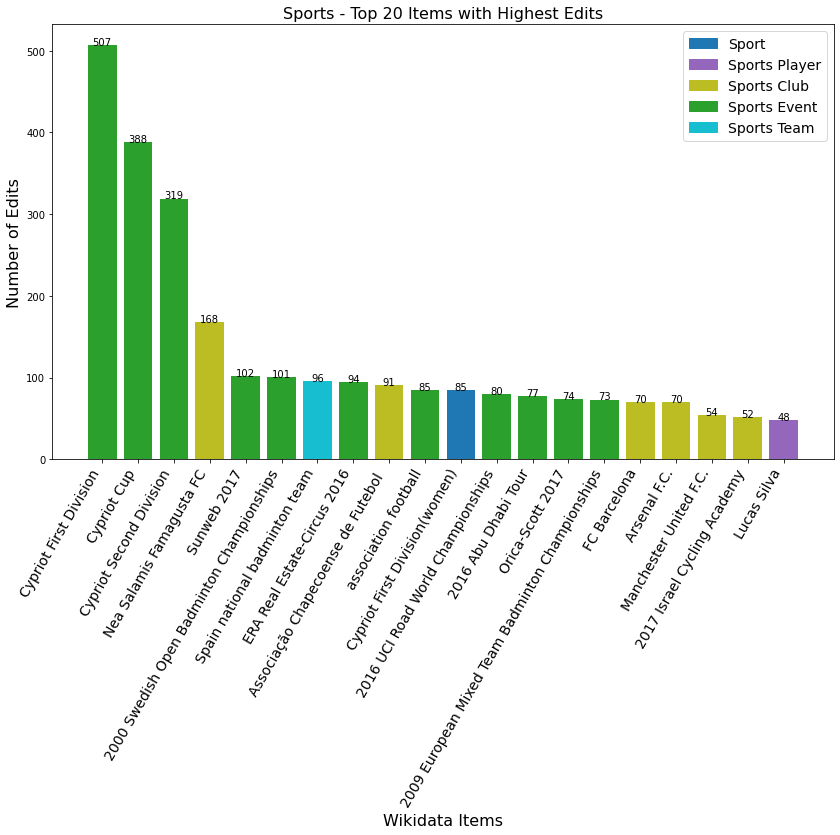

In [98]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:green', 'tab:green', 'tab:green', 'tab:olive', 'tab:green',
           'tab:green', 'tab:cyan', 'tab:green', 'tab:olive', 'tab:green',
           'tab:blue', 'tab:green', 'tab:green', 'tab:green', 'tab:green',
           'tab:olive', 'tab:olive', 'tab:olive', 'tab:olive', 'tab:purple']

sport = mpatches.Patch(color='tab:blue', label='Sport')
sports_player = mpatches.Patch(color='tab:purple', label='Sports Player')
sports_club = mpatches.Patch(color='tab:olive', label='Sports Club')
sports_event = mpatches.Patch(color='tab:green', label='Sports Event')
sports_team = mpatches.Patch(color='tab:cyan', label='Sports Team')

plt.legend(handles=[sport, sports_player, sports_club, sports_event, sports_team], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Sports - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [99]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [100]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
195,Q2536715,3,0,2,1,0,2,91,42
331,Q2736,14,1,2,0,0,6,85,29
6557,Q27889974,0,1,0,0,0,1,46,27
11112,Q27927836,0,1,0,0,0,0,42,23
11104,Q27927413,0,0,1,0,0,0,42,22
11109,Q27927819,0,1,0,0,0,1,34,19
12585,Q937857,1,0,0,0,0,1,28,19
3138,Q23045163,0,2,0,0,0,0,21,18
344,Q7156,7,1,2,4,0,4,70,17
417,Q18656,0,0,0,1,0,5,54,17


In [101]:
user_item_labels = ['Associação Chapecoense de Futebol', 'association football', 'Moise Kean', 'Tiago da Rocha Vieira', 'Guilherme Gimenez de Souza',
                     'Ailton Cesar Junior Alves da Silva', 'association football player', '2016 Japanese Grand Prix', 'FC Barcelona', 'Manchester United F.C.', 
                     '2016 Brazilian Grand Prix', '2016 Abu Dhabi Grand Prix', '2016 United States Grand Prix', '2016 Mexican Grand Prix', 'Vegas Golden Knights',  
                     'Sérgio Manoel Barbosa Santos', '2016–17 UEFA Europa League knockout phase', 'Alexander Isak', 'Usain Bolt', 'Chelsea F.C']

# Inserting item labels into restore users dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [102]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
195,Q2536715,Associação Chapecoense de Futebol,3,0,2,1,0,2,91,42
331,Q2736,association football,14,1,2,0,0,6,85,29
6557,Q27889974,Moise Kean,0,1,0,0,0,1,46,27
11112,Q27927836,Tiago da Rocha Vieira,0,1,0,0,0,0,42,23
11104,Q27927413,Guilherme Gimenez de Souza,0,0,1,0,0,0,42,22
11109,Q27927819,Ailton Cesar Junior Alves da Silva,0,1,0,0,0,1,34,19
12585,Q937857,association football player,1,0,0,0,0,1,28,19
3138,Q23045163,2016 Japanese Grand Prix,0,2,0,0,0,0,21,18
344,Q7156,FC Barcelona,7,1,2,4,0,4,70,17
417,Q18656,Manchester United F.C.,0,0,0,1,0,5,54,17


Text(0.5, 1.0, 'Sports - Top 20 Items with Highest Users')

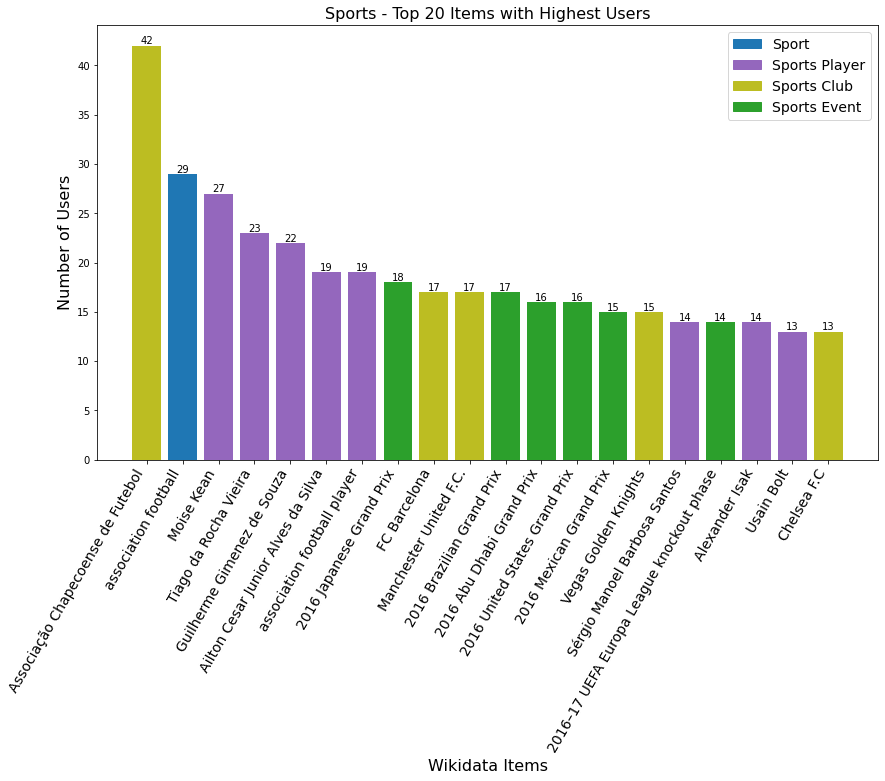

In [109]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.15, str(r), horizontalalignment='center')


colours = ['tab:olive', 'tab:blue', 'tab:purple', 'tab:purple', 'tab:purple',
           'tab:purple', 'tab:purple', 'tab:green', 'tab:olive', 'tab:olive',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:olive',
           'tab:purple', 'tab:green', 'tab:purple', 'tab:purple', 'tab:olive']

sport = mpatches.Patch(color='tab:blue', label='Sport')
sports_player = mpatches.Patch(color='tab:purple', label='Sports Player')
sports_club = mpatches.Patch(color='tab:olive', label='Sports Club')
sports_event = mpatches.Patch(color='tab:green', label='Sports Event')

plt.legend(handles=[sport, sports_player, sports_club, sports_event], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Sports - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [110]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [111]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print("Items and the number of times they occurred in top 20 reverts, merges, restores and undos")
print(common_20)

Items and the number of times they occurred in top 20 reverts, merges, restores and undos
Q7156        6
Q2536715     5
Q2736        5
Q5372        3
Q18656       3
Q23045163    2
Q142794      2
Q9616        2
Q155965      2
Q615         2
Q25239572    2
Q17515       2
Q83488       2
Q2599716     2
Q46896       2
Q245970      2
Q12984       1
Q23045140    1
Q27927819    1
Q25369       1
Name: qid, dtype: int64


The following items were selected:
- FC Barcelona Q7156
- Associação Chapecoense de Futebol Q2536715
- association football Q2736

In [112]:
# Storing the revisions of the selected items in CSV files
# rev[rev['qid'] == 'Q7156'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/sports/FCBarcelona_Q7156.csv')
# rev[rev['qid'] == 'Q2536715'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/sports/AssocFutebol_Q2536715.csv')
# rev[rev['qid'] == 'Q2736'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/sports/assocfootball_Q2736.csv')